In [ ]:
### Code for generating temporal gene trajectory clustering of upregulated DGEs in old vs young mice at day 37 shown in Figure 2

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os

from scipy.cluster.hierarchy import dendrogram
from scipy.stats import mannwhitneyu
from similaritymeasures import frechet_dist
from sklearn.cluster import AgglomerativeClustering
from statsmodels.stats.multitest import multipletests

In [4]:
import session_info
session_info.show()

# Make sure to use similaritymeasures v.0.5.0

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs)

In [6]:
input_dir = "/home/davidlauer/data/LungAging/data/Splines_clustering/"
output_dir = "/home/davidlauer/data/LungAging/data/Splines_clustering/output/"

### Pseudobulk

In [6]:
pseudobulk = pd.read_csv(input_dir + "mean_expression_pseudobulk.csv", index_col = 0)
pseudobulk

,young_d0,young_d3,young_d10,young_d20,young_d30,young_d37,old_d0,old_d3,old_d10,old_d20,old_d30,old_d37
0610005C13Rik,0.000410,0.000443,0.000085,0.000418,0.000167,0.001119,0.000507,0.000516,0.000211,0.000442,0.000338,0.000465
0610009B22Rik,0.005476,0.007234,0.008342,0.005474,0.007350,0.003143,0.005796,0.007448,0.010075,0.010592,0.009748,0.002849
0610009E02Rik,0.001955,0.001635,0.002051,0.001394,0.002864,0.000446,0.001488,0.002286,0.002506,0.001409,0.001396,0.000529
0610009L18Rik,0.003965,0.003688,0.002188,0.003763,0.001828,0.001177,0.004548,0.003171,0.002720,0.003956,0.003470,0.002083
0610010F05Rik,0.023668,0.020061,0.025630,0.029140,0.029273,0.022588,0.017539,0.016297,0.019756,0.023335,0.024917,0.036689
...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s40,0.000049,0.000050,0.000000,0.000000,0.000122,0.000050,0.000049,0.000159,0.000000,0.000085,0.000000,0.000139
n-R5s47,0.000023,0.000000,0.000000,0.000000,0.000120,0.000000,0.000035,0.000000,0.000083,0.000000,0.000050,0.000000
n-R5s54,0.000038,0.000000,0.000000,0.000000,0.000124,0.000000,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000
n-R5s89,0.000000,0.000041,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000


### d37 DGEs old vs young Gene List (new)

In [8]:
diffxpy_d37 = pd.read_csv("/home/davidlauer/data/LungAging/data/Splines/diffxpy_young_vs_old_d37.txt", sep = "\t", index_col = 0)
diffxpy_d37.head()

,pval,qval,log2fc,pct.young,pct.old
gene,,,,,
mt-Rnr2,0.0,0.0,0.570065,0.923309,0.989379
Btaf1,0.0,0.0,0.720610,0.030746,0.096262
Bsg,0.0,0.0,-1.080573,0.170553,0.122076
Oaz2,0.0,0.0,-0.791618,0.063580,0.049610
Oat,0.0,0.0,-0.688680,0.063696,0.056870


In [9]:
dge_d37 = diffxpy_d37.loc[diffxpy_d37["qval"] <= 0.05]
dge_d37 = list(dge_d37.loc[dge_d37["log2fc"] >= 0.25].index)
len(dge_d37)

847

In [11]:
pseudobulk_d37_dge = pseudobulk.filter(items = dge_d37, axis = 0)
pseudobulk_d37_dge

,young_d0,young_d3,young_d10,young_d20,young_d30,young_d37,old_d0,old_d3,old_d10,old_d20,old_d30,old_d37
mt-Rnr2,3.400963,3.202875,2.468605,3.292729,3.958802,3.585716,3.061081,3.163879,2.128320,2.730485,4.065953,4.475303
Btaf1,0.028551,0.035573,0.026745,0.025629,0.049992,0.029043,0.035142,0.041066,0.029057,0.030175,0.052948,0.073467
Dnajc3,0.228934,0.198271,0.189416,0.188107,0.226973,0.145122,0.281939,0.212543,0.189053,0.225254,0.278685,0.352260
Npm1,0.372241,0.364058,0.431489,0.515681,0.467618,0.385280,0.398782,0.331558,0.389655,0.463213,0.405482,0.610130
Smarca5,0.247489,0.191001,0.193545,0.253911,0.234945,0.213608,0.216435,0.133448,0.145829,0.171458,0.175043,0.359233
...,...,...,...,...,...,...,...,...,...,...,...,...
Gimap3,0.036944,0.074095,0.041055,0.036506,0.059454,0.035110,0.063186,0.090459,0.083297,0.059553,0.058740,0.044965
Pola1,0.014530,0.009035,0.012577,0.016783,0.019537,0.024187,0.011696,0.010300,0.011896,0.011270,0.014341,0.035523
Nol10,0.019071,0.022983,0.021779,0.027769,0.028879,0.024622,0.018912,0.015401,0.021181,0.021728,0.020691,0.035755
Peak1,0.026863,0.036287,0.031754,0.035226,0.044816,0.029639,0.029543,0.040986,0.034746,0.033416,0.035158,0.041172


In [12]:
pseudobulk_d37_dge_old = pseudobulk_d37_dge.filter(items = ["old_d0", "old_d3", "old_d10", "old_d20", "old_d30", "old_d37"], axis = "columns")
pseudobulk_d37_dge_old = pseudobulk_d37_dge_old.transpose()
pseudobulk_d37_dge_old.index = [0,3,10,20,30,37]
pseudobulk_d37_dge_old.index.name = 'timepoint'

pseudobulk_d37_dge_young = pseudobulk_d37_dge.filter(items = ["young_d0", "young_d3", "young_d10", "young_d20", "young_d30", "young_d37"], axis = "columns")
pseudobulk_d37_dge_young = pseudobulk_d37_dge_young.transpose()
pseudobulk_d37_dge_young.index = [0,3,10,20,30,37]
pseudobulk_d37_dge_young.index.name = 'timepoint'

In [13]:
pseudobulk_d37_dge_old_zscore = stats.zscore(pseudobulk_d37_dge_old, axis = 0)

In [14]:
pseudobulk_d37_dge_old_zscore.to_csv("/home/davidlauer/data/LungAging/data/Splines_clustering/frechet_distances_dge_d37/pseudobulk_old_mice_zscore_logfc025_qval005_dge_d37.csv",
                     header = True, index = True, encoding = "utf-8")

In [12]:
%%time

dm_pseudobulk_d37_dge_old_zscore = pseudobulk_d37_dge_old_zscore.corr(method = frechet_dist)
for i in range(dm_pseudobulk_d37_dge_old_zscore.shape[0]):
    dm_pseudobulk_d37_dge_old_zscore.iloc[i,i] = 0

dm_pseudobulk_d37_dge_old_zscore

CPU times: user 1min 13s, sys: 129 ms, total: 1min 13s
Wall time: 1min 13s


,mt-Rnr2,Btaf1,Dnajc3,Npm1,Smarca5,Brd2,Nek7,Sp140,Edem1,Spcs2,...,0610010F05Rik,Palmd,Ighd,Rufy2,Mettl14,Gimap3,Pola1,Nol10,Peak1,Bcl11b
mt-Rnr2,0.000000,0.509389,0.731074,1.026865,1.091300,1.874142,0.562219,0.804110,0.836301,1.187101,...,0.738365,1.326351,2.553573,1.112701,0.823428,2.929871,1.176086,1.104499,1.383802,2.126081
Btaf1,0.509389,0.000000,1.012211,0.913267,0.931401,2.246115,0.367187,0.761067,1.228967,1.579767,...,0.562446,1.607488,2.946239,0.827867,0.504030,3.322537,0.767160,0.847509,1.359924,2.148239
Dnajc3,0.731074,1.012211,0.000000,0.855970,0.738089,2.084511,0.645024,0.912470,1.067363,1.418164,...,1.282899,0.848595,2.784635,0.634555,1.156417,3.160933,0.931206,0.992785,1.990945,1.986635
Npm1,1.026865,0.913267,0.855970,0.000000,0.674715,2.339994,1.063436,0.891858,1.322846,1.673647,...,0.583828,1.451247,3.040118,0.571182,0.575350,3.416416,0.532201,0.428223,1.134975,2.242118
Smarca5,1.091300,0.931401,0.738089,0.674715,0.000000,2.425969,1.081570,0.777308,1.408821,1.759621,...,1.031445,0.846731,3.126092,0.175155,0.904964,3.502391,0.679752,0.741332,1.739491,2.328092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gimap3,2.929871,3.322537,3.160933,3.416416,3.502391,1.076422,3.256408,3.171303,2.093570,1.742770,...,3.407196,2.657448,1.326443,3.523792,3.384163,0.000000,3.618258,3.515590,2.696722,1.174299
Pola1,1.176086,0.767160,0.931206,0.532201,0.679752,2.541836,0.917329,0.911197,1.524688,1.875488,...,0.437721,1.526483,3.241960,0.504597,0.429243,3.618258,0.000000,0.454673,1.416664,2.443960
Nol10,1.104499,0.847509,0.992785,0.428223,0.741332,2.439168,0.997678,0.741641,1.422020,1.772820,...,0.518070,1.588063,3.139292,0.566177,0.509592,3.515590,0.454673,0.000000,1.353745,2.341291
Peak1,1.383802,1.359924,1.990945,1.134975,1.739491,2.075001,1.345921,1.739801,1.398654,1.477815,...,1.211950,2.586222,2.625258,1.564336,1.109627,2.696722,1.416664,1.353745,0.000000,1.522423


In [15]:
dm_pseudobulk_d37_dge_old_zscore.to_csv("/home/davidlauer/data/LungAging/data/Splines_clustering/frechet_distances_dge_d37/pseudobulk_frechet_distance_old_mice_zscore_logfc025_qval005_dge_d37.csv",
                     header = True, index = True, encoding = "utf-8")

In [23]:
#dm_pseudobulk_d37_dge_old_zscore = pd.read_csv("/home/davidlauer/data/LungAging/data/Splines_clustering/frechet_distances_dge_d37/pseudobulk_frechet_distance_old_mice_zscore_logfc025_qval005_dge_d37.csv",
                                               #index_col = 0)

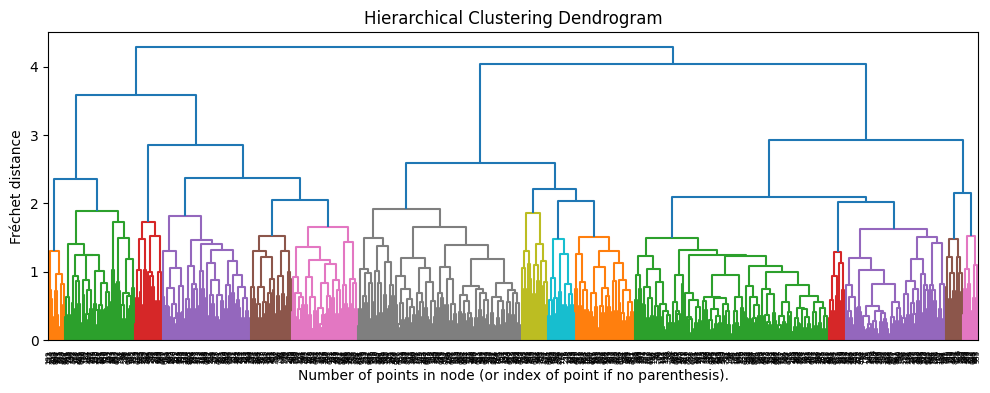

CPU times: user 2.92 s, sys: 246 ms, total: 3.16 s
Wall time: 2.99 s


In [13]:
%%time

# setting distance_threshold=0 ensures we compute the full tree.
ac = AgglomerativeClustering(metric='precomputed', linkage='complete', distance_threshold=0, n_clusters=None)
ac.fit(X=dm_pseudobulk_d37_dge_old_zscore)

plt.figure(figsize=(12,4))
plt.title('Hierarchical Clustering Dendrogram')
dend = plot_dendrogram(ac, truncate_mode=None, color_threshold=2, orientation='top')
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.ylabel('Fréchet distance')
plt.show()

Cluster 1
['Edem1' 'Spcs3' 'Ciita' 'Rbm3' 'Rpl23' 'Psme2' 'Rps27a' 'Prdx4' 'Ctss'
 'Psma7' 'Csnk1a1' 'Psap' 'Ctsl' 'Itm2c' 'Manf' 'Fkbp5' 'Msr1' 'Ndufa1'
 'Tuba1b' 'Irf8' 'Srp9' 'Cd63' 'Mrpl18' 'Txn1' 'Mpeg1' 'Clptm1l' 'H13'
 'March1' 'Eif2ak2' 'Bhlhe41' 'Mafb' 'Psmd12' 'Grb2' 'Slc6a6' 'Dab2'
 'Nampt' 'Ctsk' 'Mocs2' 'Sh3kbp1' 'Samd9l' 'Eid1' 'Atp6v1d' 'Olfm1' 'Naaa'
 'Tcp1' 'Ifih1' 'Nln' 'Psmd2' 'Aebp2' 'Ptpn22' 'Etf1' 'Etfa' 'Qk' 'Atg5'
 'Mgat2' 'Lactb' 'Papola' 'Atp6v1a' 'Spp1' 'F7' 'Psmd11' 'Snx6' 'Erap1'
 'Sp110' 'Ufsp2' 'Romo1' 'Aif1' 'Cggbp1' 'Pros1' 'Rab7b' 'Malt1' 'Dtnbp1'
 'Svbp' 'Faim' 'Mertk' 'Slc7a2' 'Lipa' 'Ms4a7' 'Erp44' 'Fnip2' 'Nsmce2'
 'Rnf149' 'Abca1' 'Lrrc58' 'Hip1' 'Snrpb2' 'Ubash3b' 'Igbp1' 'Calu' 'Hat1'
 'Rbl2' 'Slfn8' 'Ide' 'Sfxn1' 'Rp2' 'Dars' 'Blvra' 'Atp8b4' 'Mrpl45'
 'Mospd2' 'Srp68' 'Tmem87b' 'Peak1']
Cluster size = 103

Cluster 2
['Brd2' 'Ccnd2' 'H2-T23' 'AC149090.1' 'Pura' 'Timp3' 'Ablim1' 'Gbp7'
 'Irs2' 'Rnps1' 'Cd79b' 'Fcrla' 'Myzap' 'Ms4a1' 'Xiap' 'Iglc

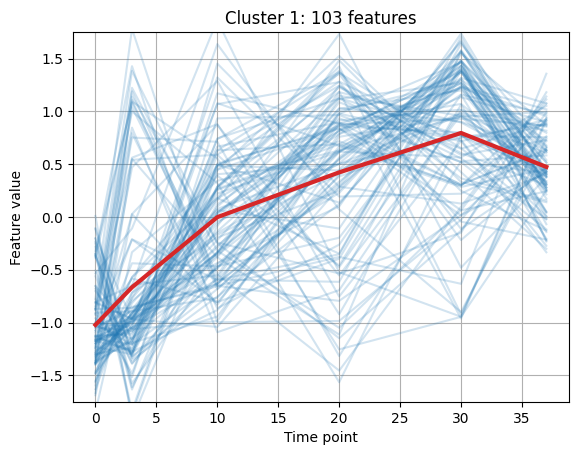

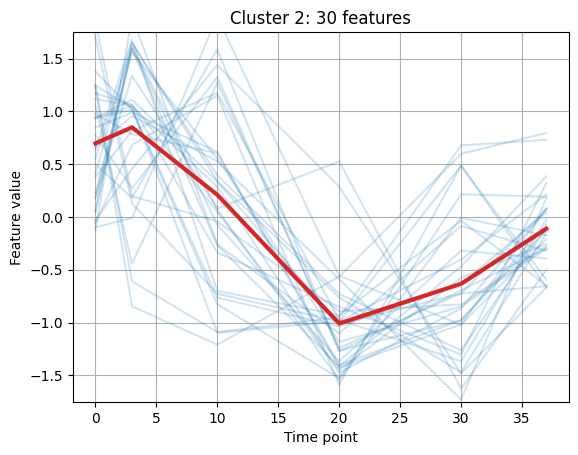

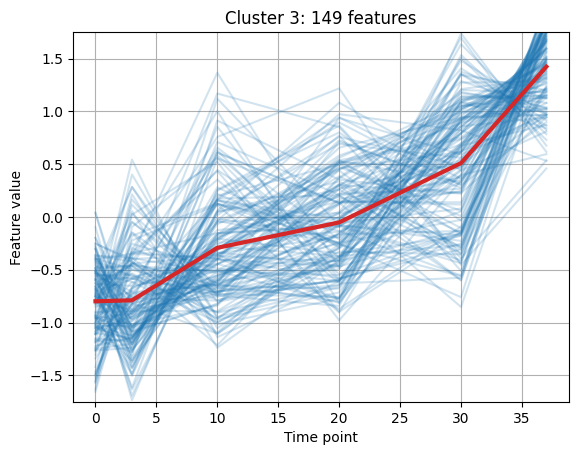

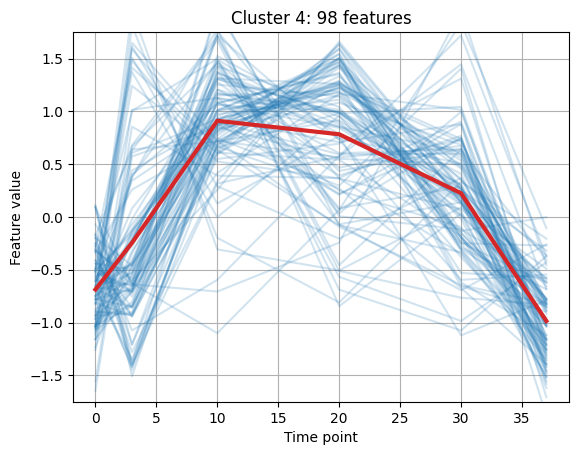

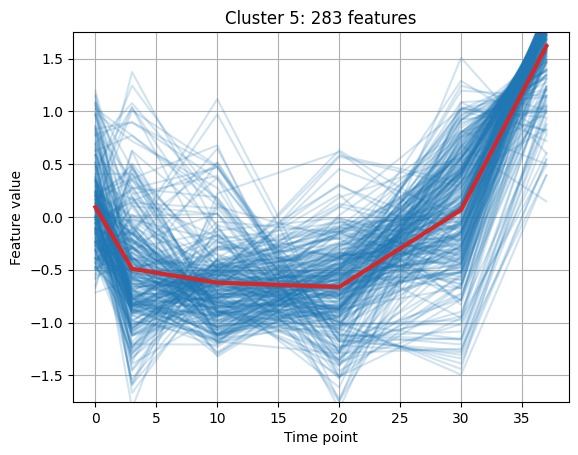

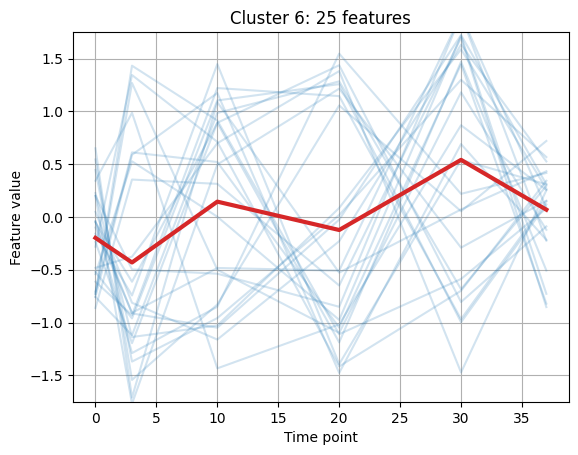

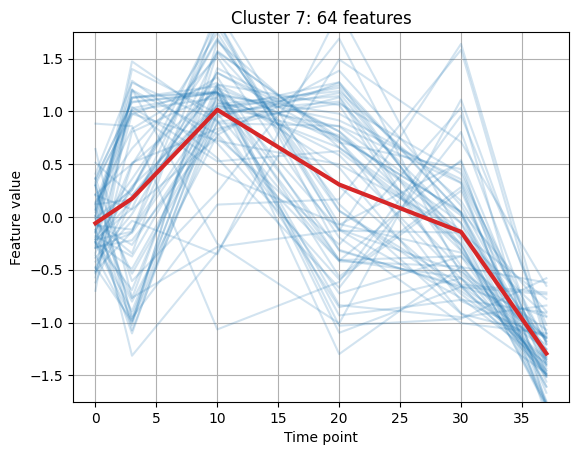

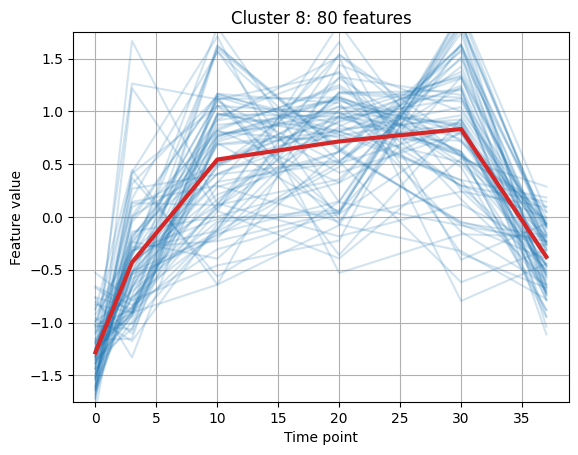

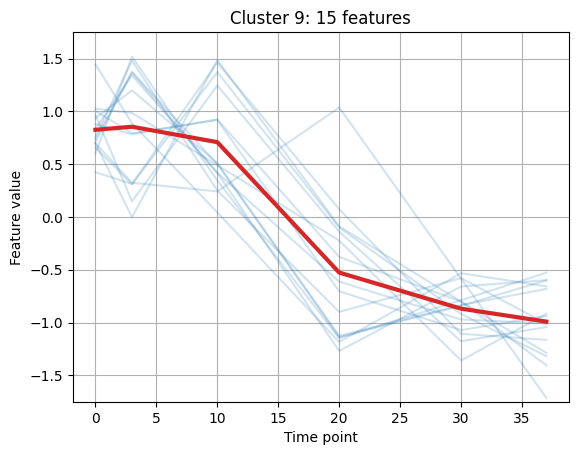

In [14]:
### Individual gene trajectories for old mice clusters 
frechet = dm_pseudobulk_d37_dge_old_zscore
expression = pseudobulk_d37_dge_old
logfc = "025"
age = "old"

n_clusters = 9
ac2 = AgglomerativeClustering(metric = 'precomputed', linkage = 'complete', n_clusters = n_clusters)
ac2.fit(X = frechet)
features_tab = pd.DataFrame()
for cluster in range(n_clusters):
    plt.figure()
    x_value = list()
    for feature in frechet.columns[ac2.labels_ == cluster]:
        x = expression[[feature]]
        x = (x-x.mean())/x.std()
        x_value.append(x)
        plt.plot(x.index, x.values, 'C0', alpha=0.2)
    x_value = pd.concat(x_value, axis=1).mean(axis=1)
    plt.plot(x_value.index, x_value.values, 'C3', alpha=1, linewidth=3)
    plt.ylim([-1.75, 1.75])
    plt.grid(True)
    #plt.xticks(x['timepoint'])
    #plt.xticks(x.index)
    plt.title('Cluster {}: {} features'.format(cluster +1, len(frechet.columns[ac2.labels_ == cluster])))
    plt.xlabel('Time point')
    plt.ylabel('Feature value')
    plt.savefig(f'/home/davidlauer/data/LungAging/data/Splines_clustering/plots_trajectories_dge_d37/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_{age}_mice_d37_dge_set_zscore_pseudobulk.pdf')
    plt.savefig(f'/home/davidlauer/data/LungAging/data/Splines_clustering/plots_trajectories_dge_d37/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_{age}_mice_d37_dge_set_zscore_pseudobulk.png')


for cluster in range(n_clusters):
    print('Cluster {}'.format(cluster + 1))
    features = frechet.columns[ac2.labels_ == cluster].values
    print(features)
    # indices = np.where(np.in1d(feature_names, features))[0]
    # print(feature_names_oryg[indices])
    print('Cluster size = {}'.format(len(features)))
    print('')
    with open(f'/home/davidlauer/data/LungAging/data/Splines_clustering/gene_clusters_dge_d37/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_{age}_mice_d37_dge_set_zscore_pseudobulk.txt', 'w') as f:
        for gene in features:
            f.write(f"{gene}\n")

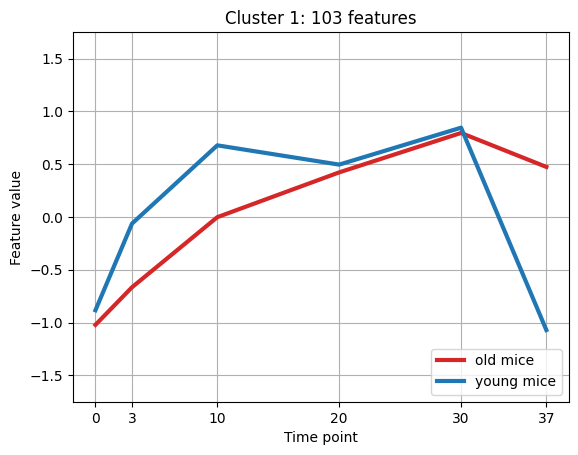

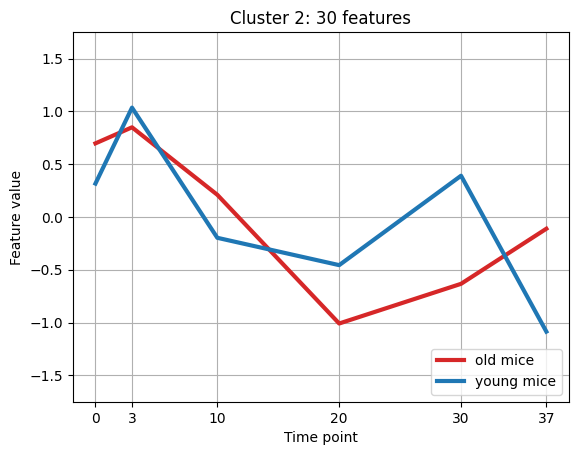

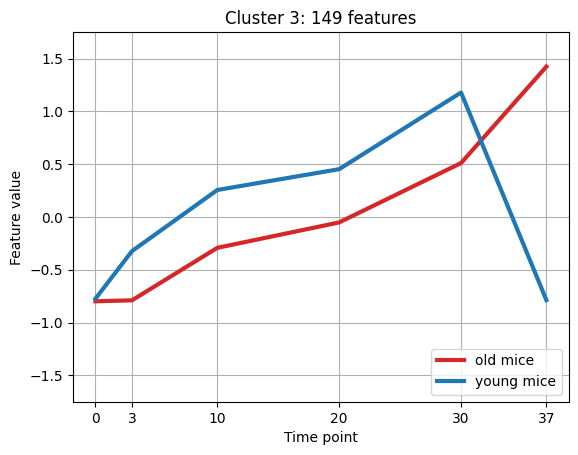

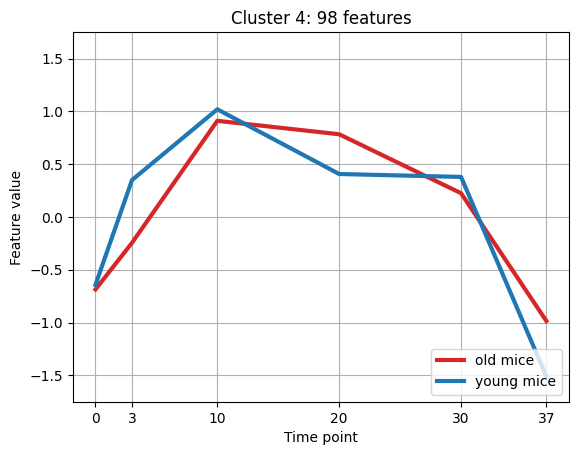

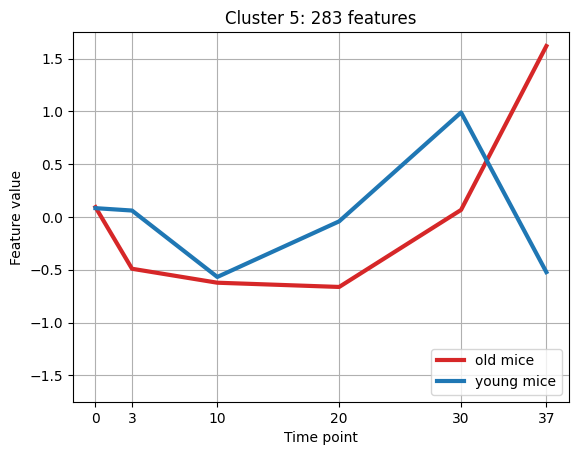

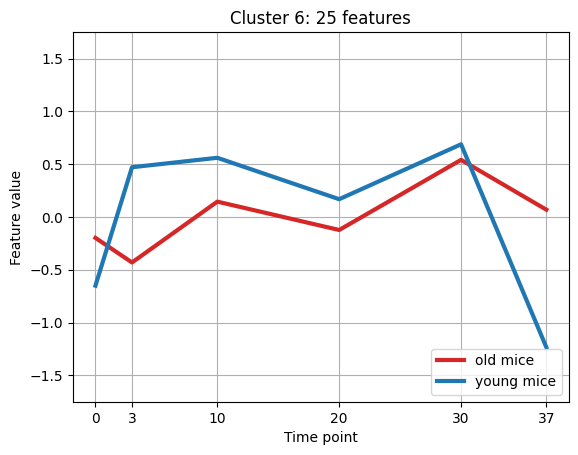

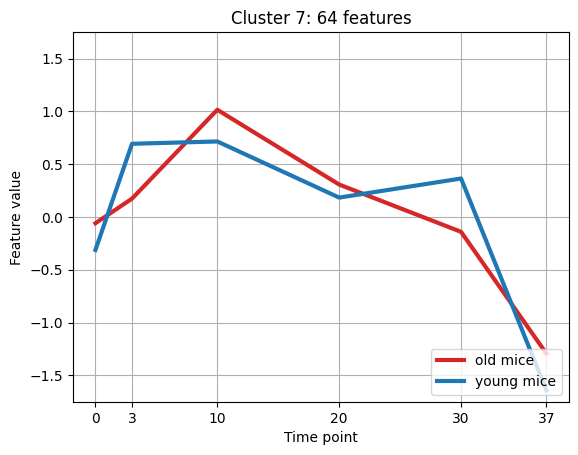

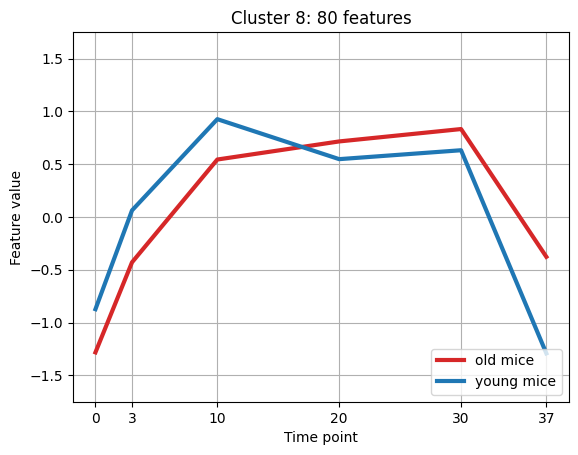

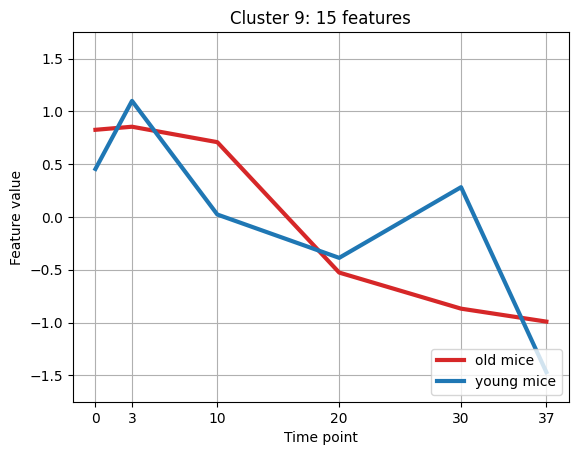

In [15]:
### Comparison of old vs. young mice
frechet = dm_pseudobulk_d37_dge_old_zscore
expression_young = pseudobulk_d37_dge_young
expression_old = pseudobulk_d37_dge_old
age = "old"

n_clusters = 9
logfc = "025"

ac2 = AgglomerativeClustering(metric = 'precomputed', linkage = 'complete', n_clusters = n_clusters)
ac2.fit(X = frechet)
for cluster in range(n_clusters):
    plt.figure()
    x_value_old = list()
    x_value_young = list()
    for feature in frechet.columns[ac2.labels_ == cluster]:
        # old mice
        x = expression_old[[feature]]
        x = (x-x.mean())/x.std()
        x_value_old.append(x)
        # young mice
        x = expression_young[[feature]]
        x = (x-x.mean())/x.std()
        x_value_young.append(x)

    x_value_old = pd.concat(x_value_old, axis=1).mean(axis=1)
    x_value_young = pd.concat(x_value_young, axis=1).mean(axis=1)

    plt.plot(x_value_old.index, x_value_old.values, 'C3', alpha = 1, linewidth = 3, label = 'old mice')
    plt.plot(x_value_young.index, x_value_young.values, 'C0', alpha = 1, linewidth = 3, label='young mice')

    plt.ylim([-1.75, 1.75])
    plt.grid(True)
    plt.xticks(x.index)
    plt.title('Cluster {}: {} features'.format(cluster +1, len(frechet.columns[ac2.labels_ == cluster])))
    plt.xlabel('Time point')
    plt.ylabel('Feature value')
    plt.legend(loc = 'lower right')

    plt.savefig(f'/home/davidlauer/data/LungAging/data/Splines_clustering/plots_trajectories_old_vs_young/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_old_vs_young_{age}_mice_pseudo_d37_dge_set_zscore_pseudobulk.pdf')
    plt.savefig(f'/home/davidlauer/data/LungAging/data/Splines_clustering/plots_trajectories_old_vs_young/cluster_{cluster +1}_qval_logfc{logfc}_ncluster{n_clusters}_old_vs_young_{age}_mice_pseudo_d37_dge_set_zscore_pseudobulk.png')
